# Edge Detection

In [1]:
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for edge detection
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(displays,titles=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(displays) == type([]):
        displays = [displays]
        
    if titles is None:
        titles = ['',]*len(displays)
        
    if not type(titles) == type([]):
        titles = [titles]
    
    nb_displays = len(displays)
    if nb_displays >4 or nb_displays < 1 :
        raise ValueError('niceDisplay_14 : displays should be a list of length 1 up to 4')
        
    if nb_displays != len(titles):
        raise ValueError('niceDisplay_14 : titles must have same length than displays')
        
    curves = False
    for i in range(0,nb_displays):
        s = plt.subplot(101+10*nb_displays+i)
        s.set_title(titles[i])
        if len(displays[i].shape)==2 and displays[i].shape[0] > 1 and displays[i].shape[1] > 1:
            # display an image
            s.imshow(displays[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # only one line, display as a curve
            plt.plot(displays[i])
            curves = True

    enlargement_h = nb_displays
    enlargement_v = nb_displays*2 if curves else nb_displays
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*enlargement_v, plSize[1]*enlargement_h) )
    plt.show()


## Comparison Between First and Second Order Detectors

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ 

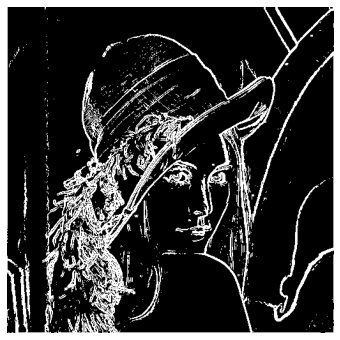

In [2]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    Gx = convolve2d(I,Sx,mode='same')
    Gy = convolve2d(I,Sy,mode='same')
    G = np.sqrt(np.square(Gx)+np.square(Gy))
    
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            if(G[i][j] > s):
                G[i][j] = 1
            else:
                G[i][j] = 0
    return G

# test
lena = np.array(Image.open('img/lena.png'))
G = SobelDetector(lena, 100)
imshow(G)

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ LaplacianDetector computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [9]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    L = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    laplacian = convolve2d(I,L,mode='same')
    output = np.zeros(laplacian.shape)
    
    w = output.shape[1]
    h = output.shape[0]

    for y in range(1, h - 1):
        for x in range(1, w - 1):
            patch = laplacian[y-1:y+2, x-1:x+2]
            currentPixel = laplacian[y, x]
            maxPatch = patch.max()
            minPatch = patch.min()
            if (currentPixel > 0):
                zeroCross = True if minPatch < 0 else False
            else:
                zeroCross = True if maxPatch > 0 else False
            if ((maxPatch - minPatch) > s) and zeroCross:
                output[y, x] = 1
    return output

**Comparison between first and second order detectors**.

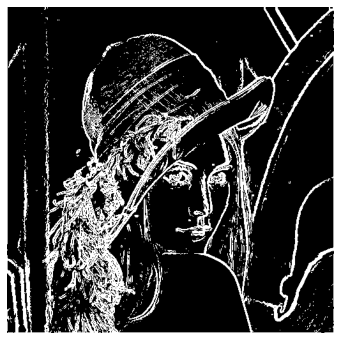

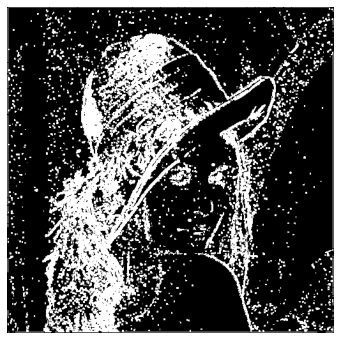

In [16]:
lena = np.array(Image.open('img/lena.png'))
Sobel = SobelDetector(lena, 85)
Laplacian = LaplacianDetector(lena, 70)

imshow(Sobel)
imshow(Laplacian)

# Thresholds;
# for sobel = 85
# for laplacian = 70
# There are other values which both detectors detect the same edges, I have chosen these values for better noise
# free results. And according to this experiment, Sobel detector does quite good job comparing to laplacian detector
# in terms of noise.

## Non maximum suppression

This section addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, I write a function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using one of the filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

In [34]:
%matplotlib notebook

# open file
tools = np.array(Image.open('img/tools.png'))

# Sobel filter
Sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

# Derivatives
Gx = convolve2d(tools,Sx,mode='same')
Gy = convolve2d(tools,Sy,mode='same')

# Gradient norm
G = np.sqrt(np.square(Gx)+np.square(Gy))

imshow_hot(orientation(Gx,Gy,G))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

These values are the direction(orthogonal to the contour) values of the edges. The tools in the image have a complex shape(curves, straight lines, circles etc.). So there are a lot of edge directions different from each others. And the pixel values indicates these directions (0,1,2,3,4) respectively (null gradient, 0, pi/4, pi/2, 3*pi/2)

The function `G=nms(Ig, Ior)` gets the gradient norm of an image, and the gradient orientation and returns an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [20]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    gradientNorm = Ig.copy()
    
    for i in range(Ior.shape[0]):
        for j in range(Ior.shape[1]):
            
            # border conditions
            if i == 0 or j == 0 or i == Ior.shape[0]-1 or j == Ior.shape[1]-1:
                gradientNorm[i][j] = 0
                continue
                
            # determine edge direction  
            direction = Ior[i][j]
            dx = 0
            dy = 0
            if direction == 1:
                dx = 1
                dy = 0
            elif direction == 2:
                dx = 1
                dy = -1
            elif direction == 3:
                dx = 0
                dy = -1
            elif direction == 4:
                dx = -1
                dy = -1
            elif direction == 0:
                # no direction, set to zero and continue
                gradientNorm[i][j] = 0
                continue
                
            # check local maxima
            if Ig[i][j] > Ig[i+dy][j+dx] and Ig[i][j] > Ig[i-dy][j-dx]:
                gradientNorm[i][j] = Ig[i][j]
            else:
                gradientNorm[i][j] = 0
                
    return gradientNorm


Experimenting the function `nms()` on images `img/tools.png` and `img/lena.png`.


Without gaussian filter


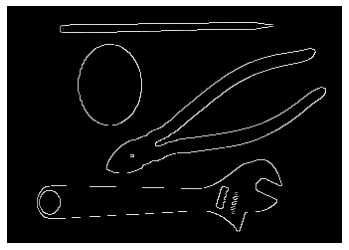

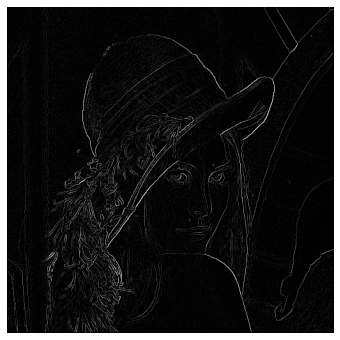

With gaussian filter


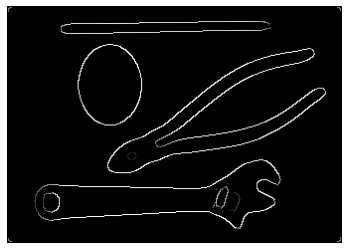

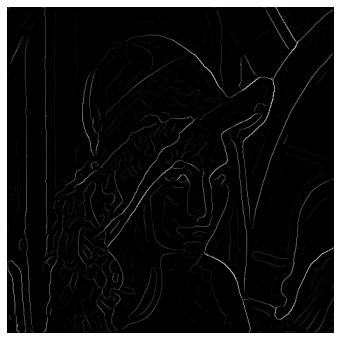

In [21]:
%matplotlib inline
### your answer below

# open file
tools = np.array(Image.open('img/tools.png'))
lena = np.array(Image.open('img/lena.png'))

# Gaussian filter
gKernel = gaussianKernel(4)

# Sobel filter
Sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
Sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

# Derivatives without gaussian filtering
Gx_tools = convolve2d(tools,Sx,mode='same')
Gy_tools = convolve2d(tools,Sy,mode='same')
Gx_lena = convolve2d(lena,Sx,mode='same')
Gy_lena = convolve2d(lena,Sy,mode='same')

# Gradient norm without gaussian filtering
G_tools = np.sqrt(np.square(Gx_tools)+np.square(Gy_tools))
G_lena = np.sqrt(np.square(Gx_lena)+np.square(Gy_lena))

# Orientation without gaussian filtering
tools_or = orientation(Gx_tools, Gy_tools, G_tools)
lena_or = orientation(Gx_lena, Gy_lena, G_lena)

# apply nms function without gaussian filtering
gN_tools = nms(G_tools, tools_or)
gN_lena = nms(G_lena, lena_or)
              
              

# Derivatives with gaussian filtering
Gx_tools_f = convolve2d(Gx_tools,gKernel,mode='same')
Gy_tools_f = convolve2d(Gy_tools,gKernel,mode='same')
Gx_lena_f = convolve2d(Gx_lena,gKernel,mode='same')
Gy_lena_f = convolve2d(Gy_lena,gKernel,mode='same')

# Gradient norm with gaussian filtering
G_tools_f = np.sqrt(np.square(Gx_tools_f)+np.square(Gy_tools_f))
G_lena_f = np.sqrt(np.square(Gx_lena_f)+np.square(Gy_lena_f))

# Orientation with gaussian filtering
tools_or_f = orientation(Gx_tools_f, Gy_tools_f, G_tools_f)
lena_or_f = orientation(Gx_lena_f, Gy_lena_f, G_lena_f)

# apply nms function with gaussian filtering
gN_tools_f = nms(G_tools_f, tools_or_f)
gN_lena_f = nms(G_lena_f, lena_or_f)


# Visualizing the results
print("Without gaussian filter")
imshow(gN_tools)
imshow(gN_lena)

print("With gaussian filter")
imshow(gN_tools_f)
imshow(gN_lena_f)




There is no effect of smoothing on the size of edges but some blurness on the edges. Why? In the nms function we try to catch maxima values in the gradient and we eliminate non maxima values. So filters like gaussian; smoothes the edges and expands non maxima areas. We could have seen the difference if we didn't use nms function but because we eliminate the non maxima values, no matter how much we use smoothing filters the result will not change.

## Effects of Smoothing in Edge Detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess.

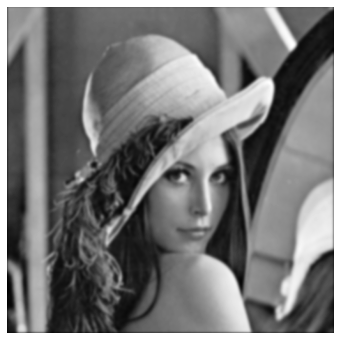

In [74]:
lena = np.array(Image.open('img/lena.png'))

G = gaussianKernel(2)
sLena = convolve2d(lena,G, mode='same')

imshow(sLena)

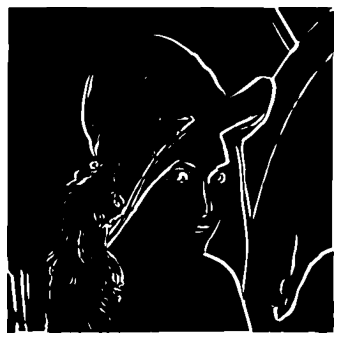

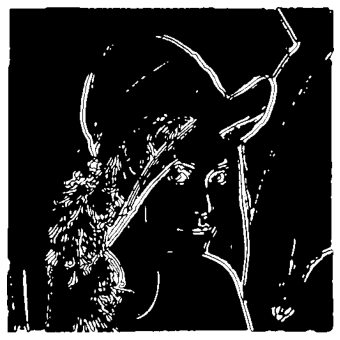

In [76]:
sobel = SobelDetector(sLena,110)
laplacian = LaplacianDetector(sLena,20)

imshow(sobel)
imshow(laplacian)

# Laplacian/Sobel differences
# second order approach / first order approach
# localization quality: sobel > laplacian
# sensitivity to noise: laplacian > sobel
# sensitivity to threshold: sobel > laplacian
# laplacian has more closed path comparing to sobel

Sobel, sigma:2.0


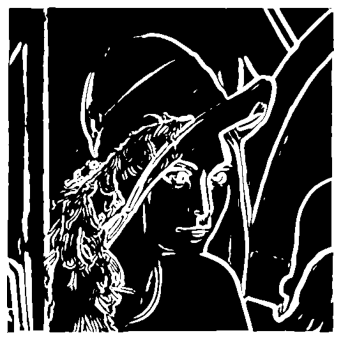

Laplacian, sigma:2.0


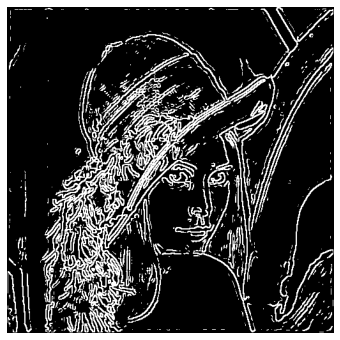

Sobel, sigma:2.4


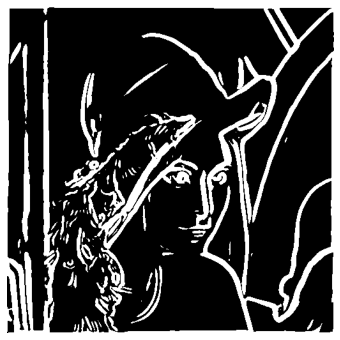

Laplacian, sigma:2.4


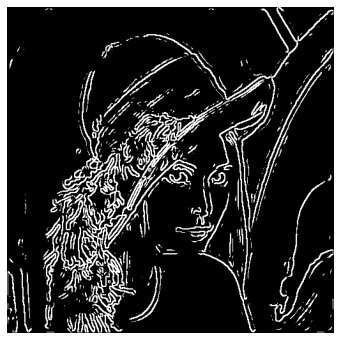

Sobel, sigma:2.8


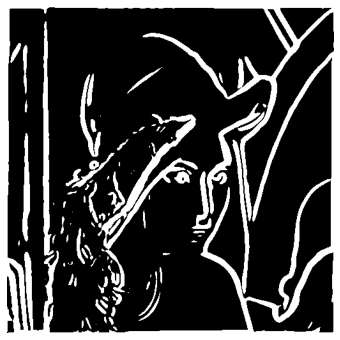

Laplacian, sigma:2.8


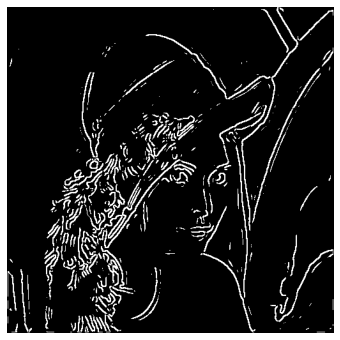

Sobel, sigma:3.2


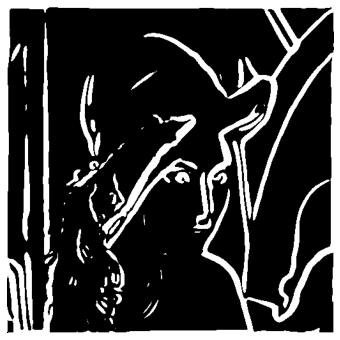

Laplacian, sigma:3.2


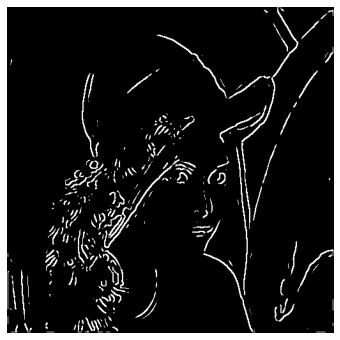

Sobel, sigma:3.6


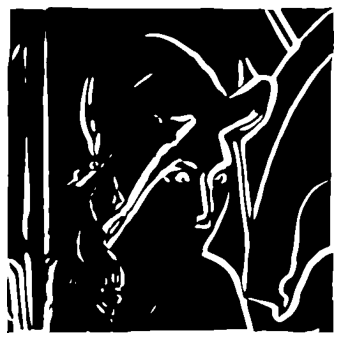

Laplacian, sigma:3.6


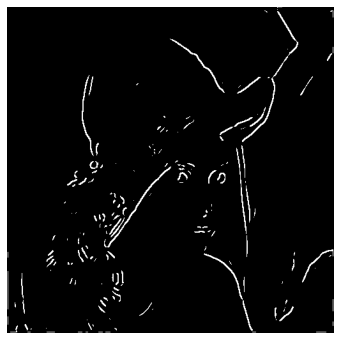

Sobel, sigma:4.0


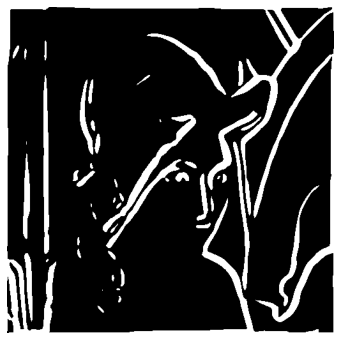

Laplacian, sigma:4.0


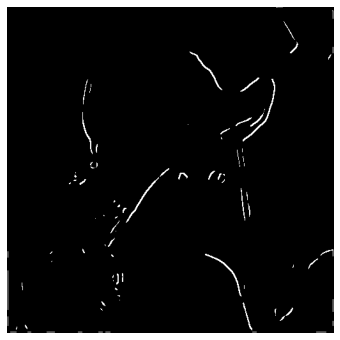

In [25]:

# Lets vary sigma = [2,4] by increasing the sigma value 0.4 at each step.

for i in range(0,6):
    G = gaussianKernel(2 + i*0.4)
    sLena = convolve2d(lena,G,mode='same')
    sobel = SobelDetector(sLena,50)
    laplacian = LaplacianDetector(sLena,2)
    # Visualizing results
    print("Sobel, sigma:"+str(2 + i*0.4))
    imshow(sobel)
    print("Laplacian, sigma:"+str(2 + i*0.4))
    imshow(laplacian)
    
    

# As the smoothness increases, noises becomes more and more blurred. So they couldn't pass the threshold and they
# disappear on the detector.


4. Lets use constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ instead of gaussian filter.

Filtered image


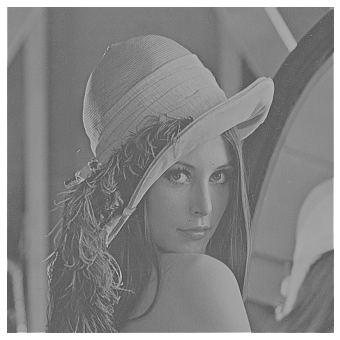

Sobel


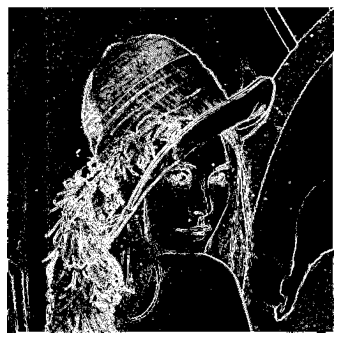

Laplacian


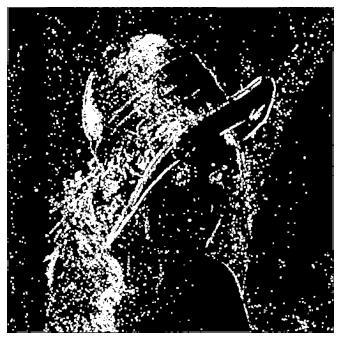

In [33]:
# Contrast enhancer filter
CEF = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])

sLena = convolve2d(lena,CEF,mode='same')
print("Filtered image")
imshow(sLena)
sobel = SobelDetector(sLena,190)
laplacian = LaplacianDetector(sLena,500)
print("Sobel")
imshow(sobel)
print("Laplacian")
imshow(laplacian)

Now lets apply a multiresolution decomposition up to a size $8\times8$ then apply the two detectors for each resolution.

In [35]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift,ifftshift

def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A

lena = np.array(Image.open('img/lena.png'))
level = 0

while lena.shape[0] >= 8:
    # Edge detection process
    sobel = SobelDetector(lena,70+level*20)
    laplacian = LaplacianDetector(lena,90+level*20)
    
    # Visualizing results
    print("Sobel, level:"+str(level))
    imshow(sobel)
    print("Laplacian, level:"+str(level))
    imshow(laplacian)
    level += 1
    
    # Anti-aliasing and subsampling process
    lenaSpectrum = fftshift(fft2(lena))
    AAFilter = antiAliasingFilter(lena.shape[0],lena.shape[1])
    f_lenaSpectrum = lenaSpectrum*AAFilter
    IDFT = ifft2(ifftshift(f_lenaSpectrum))
    filteredLena = IDFT.real
    lena = subSample2(filteredLena)
    
    

# The edges is getting thicker as we subsample the image. So, localization is getting worse in every subsampling
# process. But besides that, the amount of noise is decreasing. So on the one hand we eliminate the noise, on the
# other hand we loose precision of the localization of edges. We can start from the subsampled image and clear
# the noises at the higher resolution images. At the end we obtain more clear but also good located edges. And also
# we can try to predict the contours from these edges and fill the gaps between edges and obtain more closed paths.


Sobel, level:0


<IPython.core.display.Javascript object>

Laplacian, level:0


<IPython.core.display.Javascript object>

Sobel, level:1


<IPython.core.display.Javascript object>

Laplacian, level:1


<IPython.core.display.Javascript object>

Sobel, level:2


<IPython.core.display.Javascript object>

Laplacian, level:2


<IPython.core.display.Javascript object>

Sobel, level:3


<IPython.core.display.Javascript object>

Laplacian, level:3


<IPython.core.display.Javascript object>

Sobel, level:4


<IPython.core.display.Javascript object>

Laplacian, level:4


<IPython.core.display.Javascript object>

Sobel, level:5


<IPython.core.display.Javascript object>

Laplacian, level:5


<IPython.core.display.Javascript object>

Sobel, level:6


<IPython.core.display.Javascript object>

Laplacian, level:6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>